In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

/home/ailab/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# get data
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

2023-01-15 10:06:28.071434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 10:06:28.075196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 10:06:28.075309: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 10:06:28.075588: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
# process data

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [4]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 4
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [5]:
# monitor
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

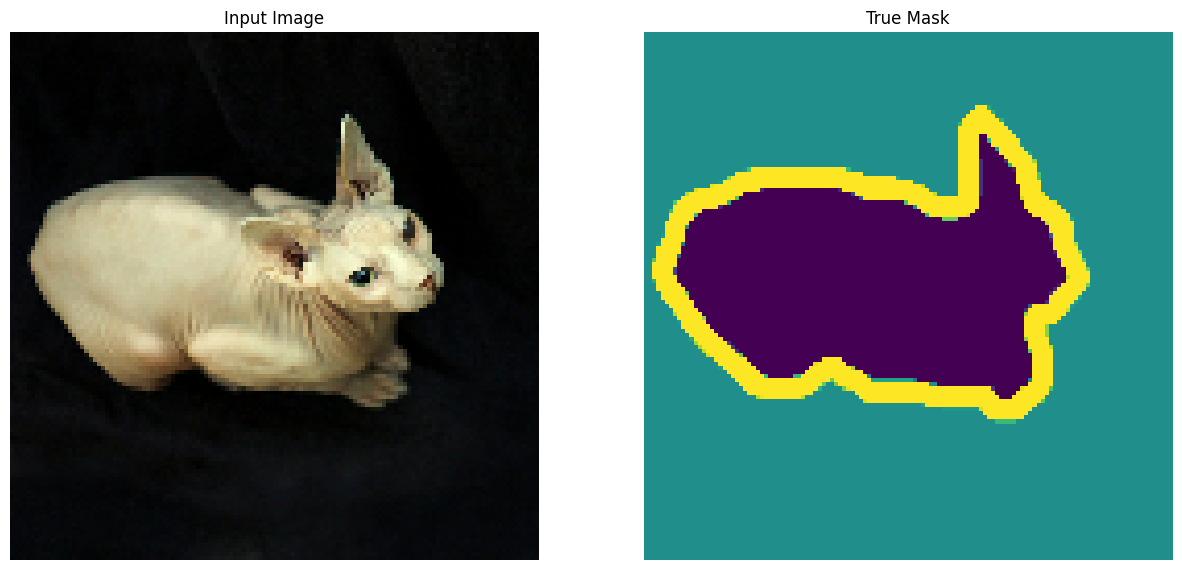

In [6]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

In [8]:
model = tf.keras.Sequential()    

# block 1
model.add(tf.keras.layers.Conv2D(64, 9, padding='same', activation='LeakyReLU', input_shape=(128, 128, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())

# block 2
model.add(tf.keras.layers.Conv2D(128, 9, padding='same', activation='LeakyReLU'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())

# block 3
model.add(tf.keras.layers.Conv2D(256, 5, padding='same', activation='LeakyReLU'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())

# block 4
model.add(tf.keras.layers.Conv2D(512, 5, padding='same', activation='LeakyReLU'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())

# block 5
model.add(tf.keras.layers.Conv2D(512, 3, padding='same', activation='LeakyReLU'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())

# upsampling
model.add(tf.keras.layers.UpSampling2D())
model.add(tf.keras.layers.Conv2D(512, 3, padding='same', activation='LeakyReLU'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.UpSampling2D())
model.add(tf.keras.layers.Conv2D(256, 3, padding='same', activation='LeakyReLU'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.UpSampling2D())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='LeakyReLU'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.UpSampling2D())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='LeakyReLU'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.UpSampling2D())
model.add(tf.keras.layers.Conv2D(3, 3, padding='same'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 128, 128, 64)      15616     
                                                                 
 batch_normalization_9 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 128)       663680    
                                                                 
 batch_normalization_10 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                                
                                                      

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])
        
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):        
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2023-01-15 10:07:27.485027: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2023-01-15 10:07:27.951788: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-15 10:07:27.952176: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-15 10:07:27.952190: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-15 10:07:27.952555: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-15 10:07:27.952597: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas loca

919/920 [============================>.] - ETA: 0s - loss: 0.7692 - accuracy: 0.6801

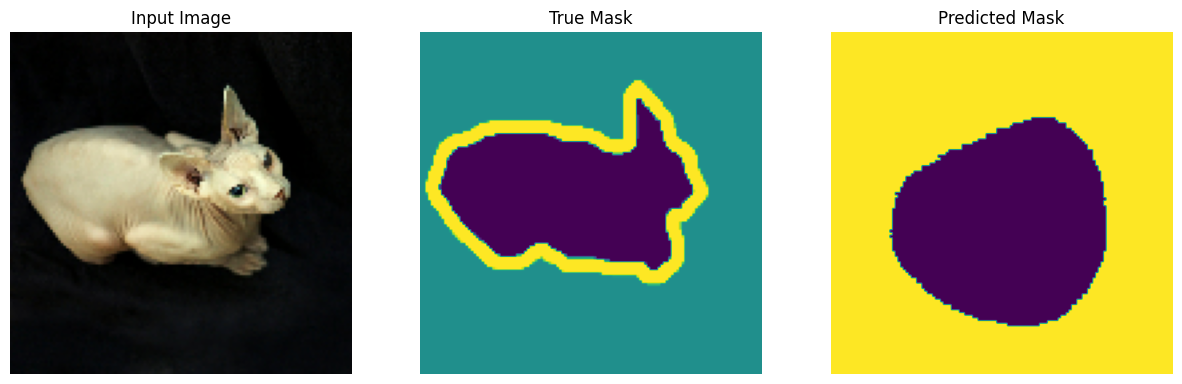


Sample Prediction after epoch 1

920/920 [==============================] - 22s 21ms/step - loss: 0.7693 - accuracy: 0.6801 - val_loss: 0.7908 - val_accuracy: 0.6868
Epoch 2/20
919/920 [============================>.] - ETA: 0s - loss: 0.6604 - accuracy: 0.7309

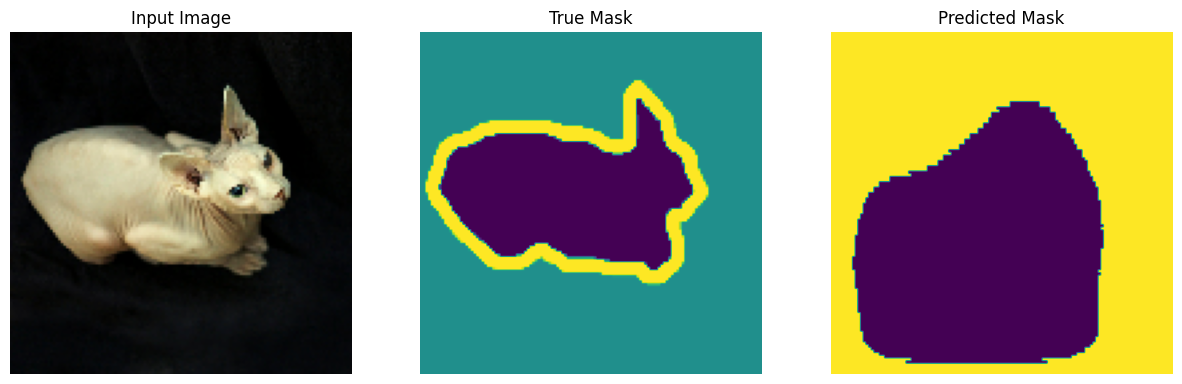


Sample Prediction after epoch 2

920/920 [==============================] - 18s 20ms/step - loss: 0.6605 - accuracy: 0.7308 - val_loss: 0.7167 - val_accuracy: 0.7005
Epoch 3/20
919/920 [============================>.] - ETA: 0s - loss: 0.5971 - accuracy: 0.7555

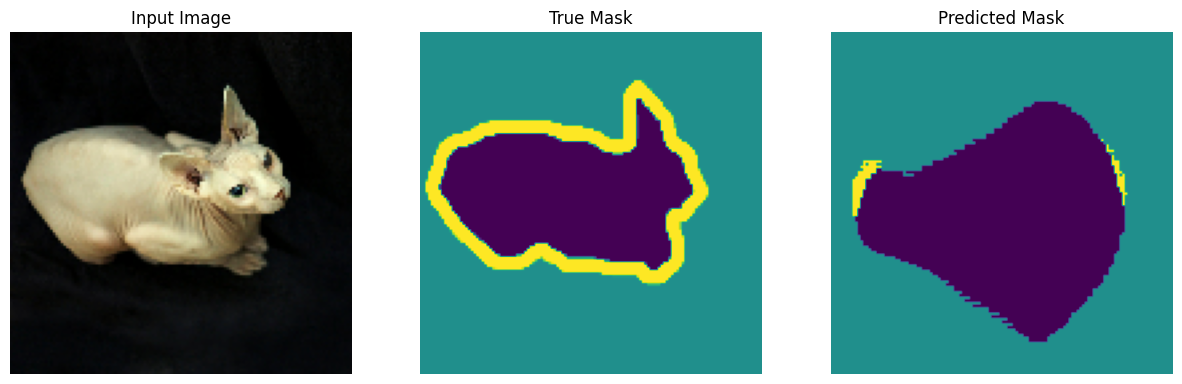


Sample Prediction after epoch 3

920/920 [==============================] - 19s 20ms/step - loss: 0.5971 - accuracy: 0.7555 - val_loss: 0.6107 - val_accuracy: 0.7483
Epoch 4/20
919/920 [============================>.] - ETA: 0s - loss: 0.5613 - accuracy: 0.7699

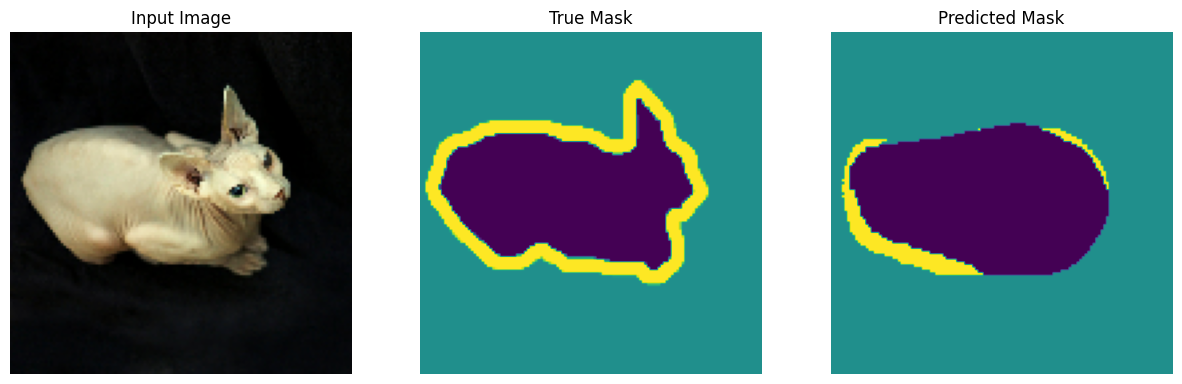


Sample Prediction after epoch 4

920/920 [==============================] - 19s 20ms/step - loss: 0.5613 - accuracy: 0.7699 - val_loss: 0.5630 - val_accuracy: 0.7692
Epoch 5/20
919/920 [============================>.] - ETA: 0s - loss: 0.5314 - accuracy: 0.7812

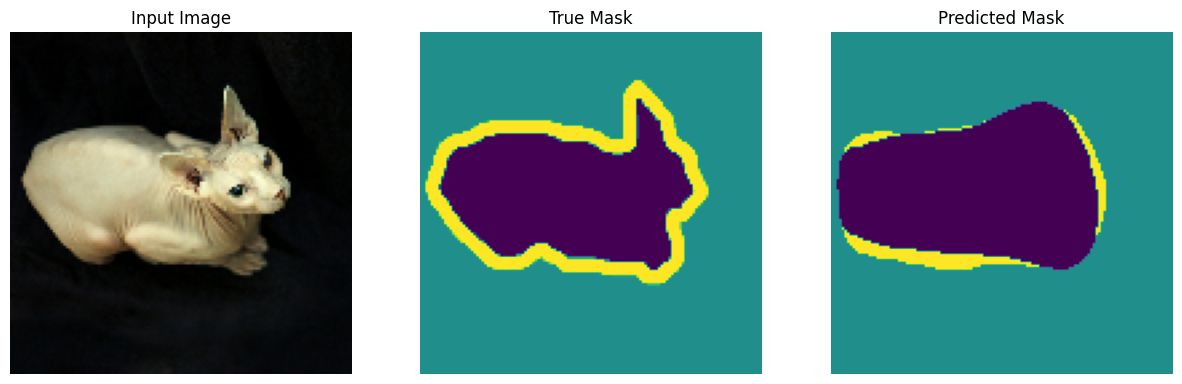


Sample Prediction after epoch 5

920/920 [==============================] - 19s 20ms/step - loss: 0.5313 - accuracy: 0.7812 - val_loss: 0.5927 - val_accuracy: 0.7570
Epoch 6/20
919/920 [============================>.] - ETA: 0s - loss: 0.4997 - accuracy: 0.7936

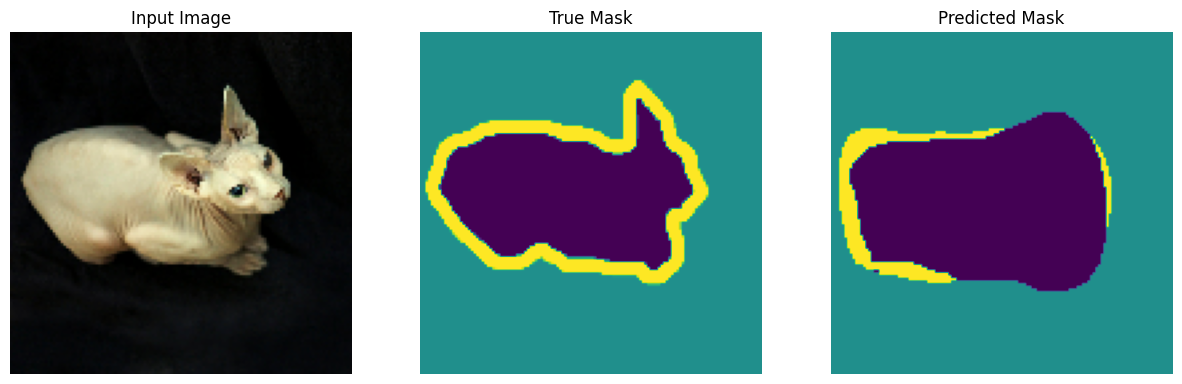


Sample Prediction after epoch 6

920/920 [==============================] - 19s 20ms/step - loss: 0.4996 - accuracy: 0.7936 - val_loss: 0.5136 - val_accuracy: 0.7961
Epoch 7/20
919/920 [============================>.] - ETA: 0s - loss: 0.4739 - accuracy: 0.8044

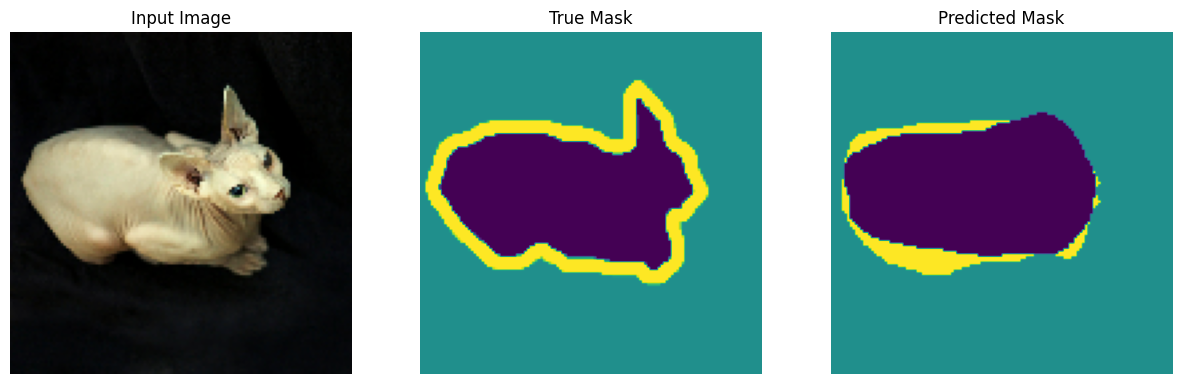


Sample Prediction after epoch 7

920/920 [==============================] - 19s 20ms/step - loss: 0.4738 - accuracy: 0.8044 - val_loss: 0.5144 - val_accuracy: 0.7852
Epoch 8/20
919/920 [============================>.] - ETA: 0s - loss: 0.4415 - accuracy: 0.8174

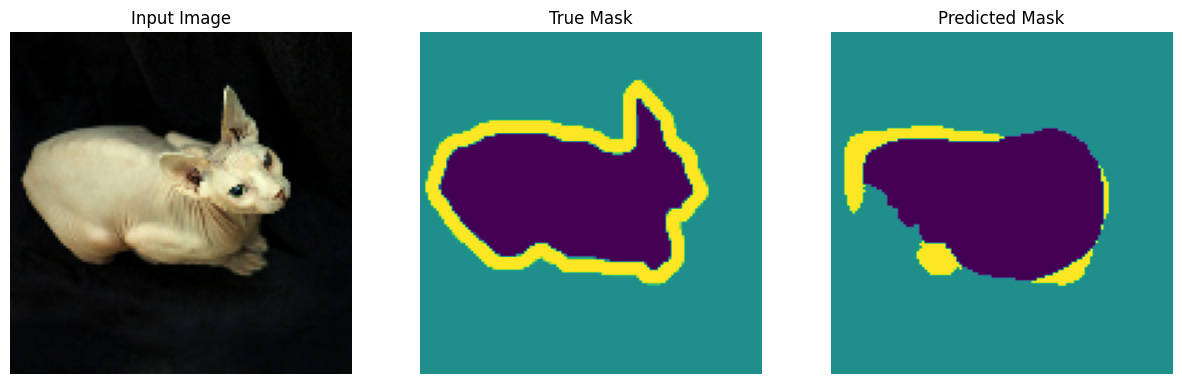


Sample Prediction after epoch 8

920/920 [==============================] - 19s 20ms/step - loss: 0.4416 - accuracy: 0.8174 - val_loss: 0.4748 - val_accuracy: 0.8025
Epoch 9/20
919/920 [============================>.] - ETA: 0s - loss: 0.3990 - accuracy: 0.8341

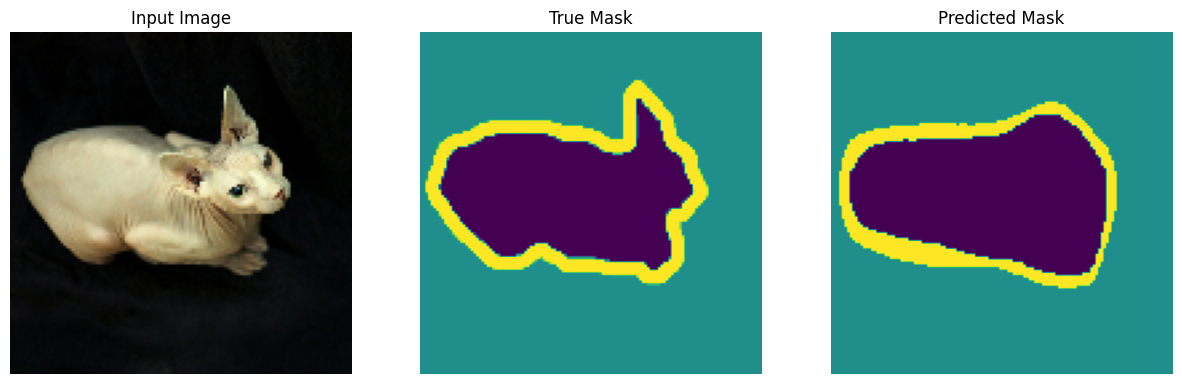


Sample Prediction after epoch 9

920/920 [==============================] - 19s 20ms/step - loss: 0.3989 - accuracy: 0.8341 - val_loss: 0.5419 - val_accuracy: 0.7914
Epoch 10/20
919/920 [============================>.] - ETA: 0s - loss: 0.3596 - accuracy: 0.8493

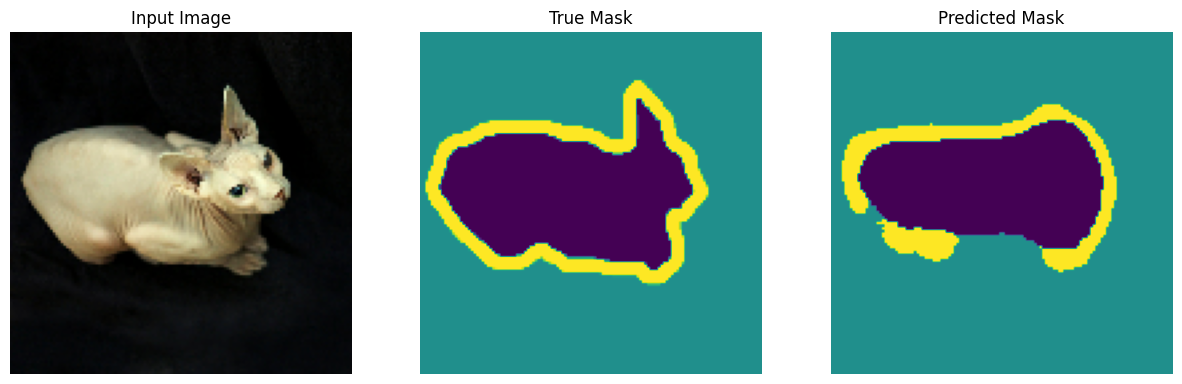


Sample Prediction after epoch 10

920/920 [==============================] - 19s 20ms/step - loss: 0.3596 - accuracy: 0.8493 - val_loss: 0.5170 - val_accuracy: 0.7911
Epoch 11/20
919/920 [============================>.] - ETA: 0s - loss: 0.3206 - accuracy: 0.8634

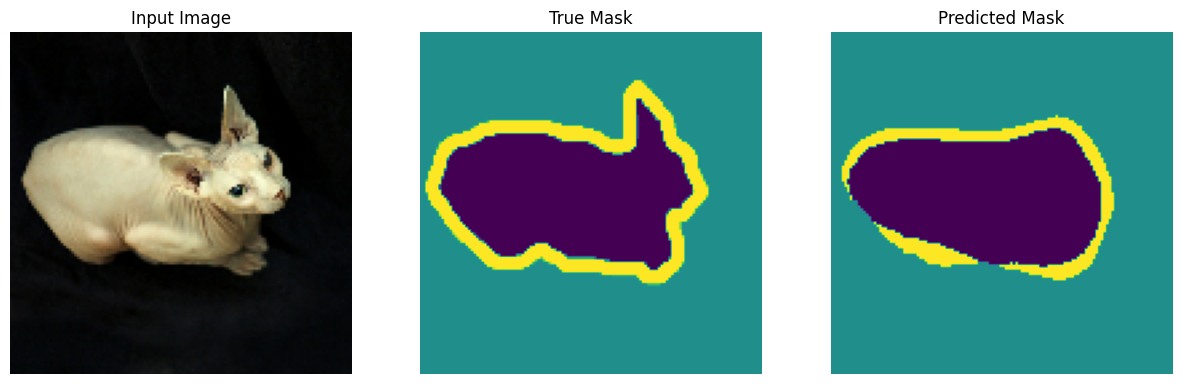


Sample Prediction after epoch 11

920/920 [==============================] - 19s 20ms/step - loss: 0.3206 - accuracy: 0.8634 - val_loss: 0.5264 - val_accuracy: 0.8006
Epoch 12/20
919/920 [============================>.] - ETA: 0s - loss: 0.2966 - accuracy: 0.8723

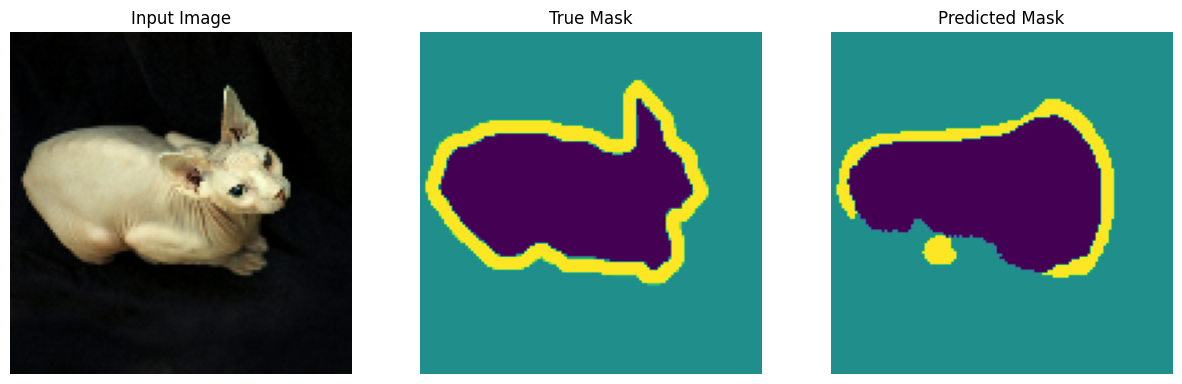


Sample Prediction after epoch 12

920/920 [==============================] - 19s 20ms/step - loss: 0.2966 - accuracy: 0.8723 - val_loss: 0.5815 - val_accuracy: 0.7889
Epoch 13/20
918/920 [============================>.] - ETA: 0s - loss: 0.2656 - accuracy: 0.8840

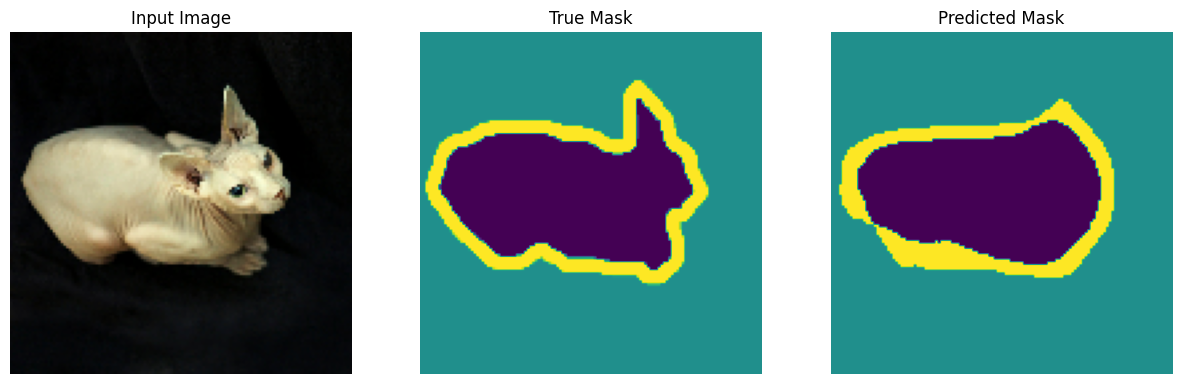


Sample Prediction after epoch 13

920/920 [==============================] - 19s 20ms/step - loss: 0.2656 - accuracy: 0.8840 - val_loss: 0.5125 - val_accuracy: 0.8076
Epoch 14/20
918/920 [============================>.] - ETA: 0s - loss: 0.2508 - accuracy: 0.8895

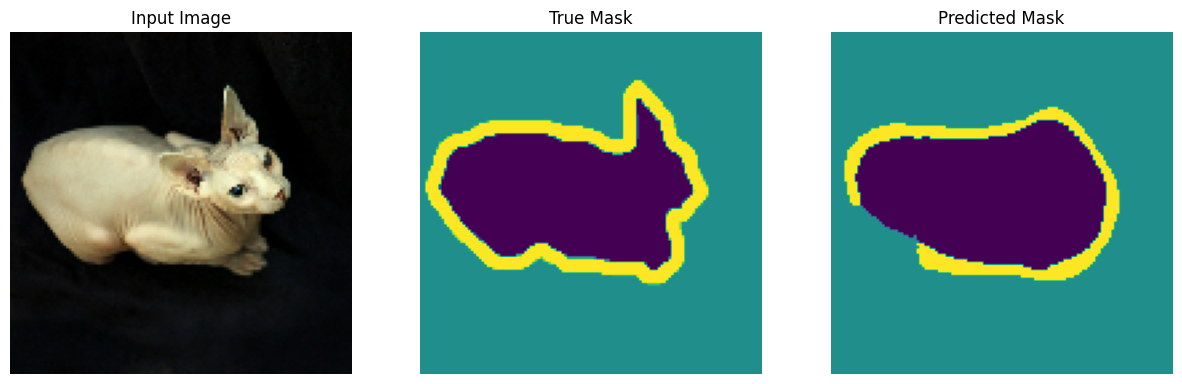


Sample Prediction after epoch 14

920/920 [==============================] - 19s 20ms/step - loss: 0.2507 - accuracy: 0.8896 - val_loss: 0.5426 - val_accuracy: 0.8129
Epoch 15/20
919/920 [============================>.] - ETA: 0s - loss: 0.2283 - accuracy: 0.8981

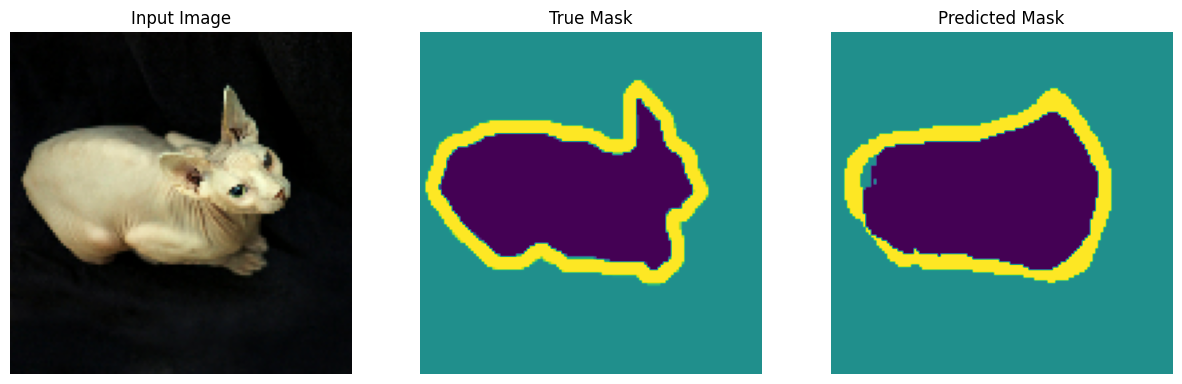


Sample Prediction after epoch 15

920/920 [==============================] - 19s 20ms/step - loss: 0.2283 - accuracy: 0.8981 - val_loss: 0.5574 - val_accuracy: 0.8074
Epoch 16/20
919/920 [============================>.] - ETA: 0s - loss: 0.2193 - accuracy: 0.9019

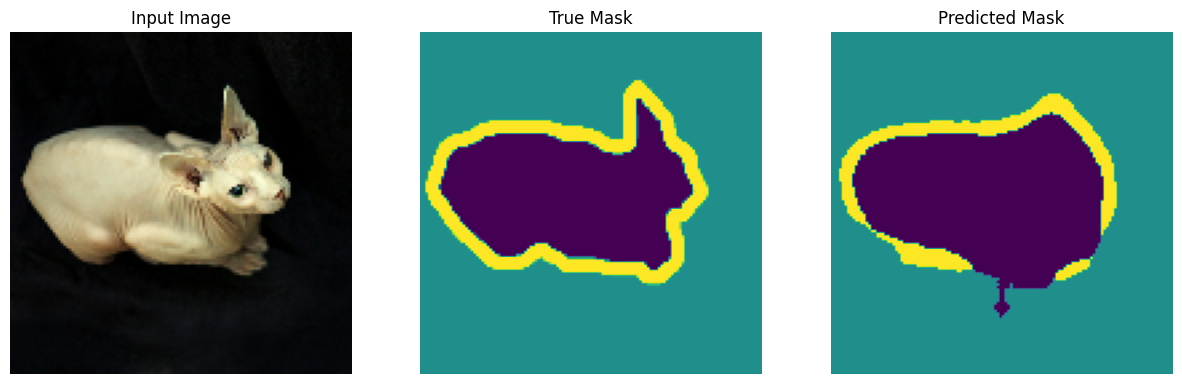


Sample Prediction after epoch 16

920/920 [==============================] - 19s 20ms/step - loss: 0.2192 - accuracy: 0.9019 - val_loss: 0.5703 - val_accuracy: 0.8020
Epoch 17/20
918/920 [============================>.] - ETA: 0s - loss: 0.2114 - accuracy: 0.9053

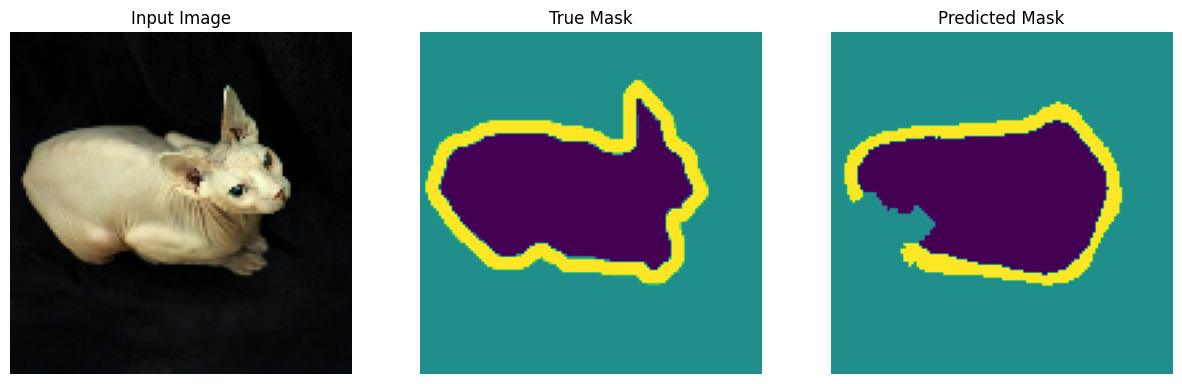


Sample Prediction after epoch 17

920/920 [==============================] - 19s 21ms/step - loss: 0.2114 - accuracy: 0.9053 - val_loss: 0.5411 - val_accuracy: 0.8111
Epoch 18/20
919/920 [============================>.] - ETA: 0s - loss: 0.1922 - accuracy: 0.9128

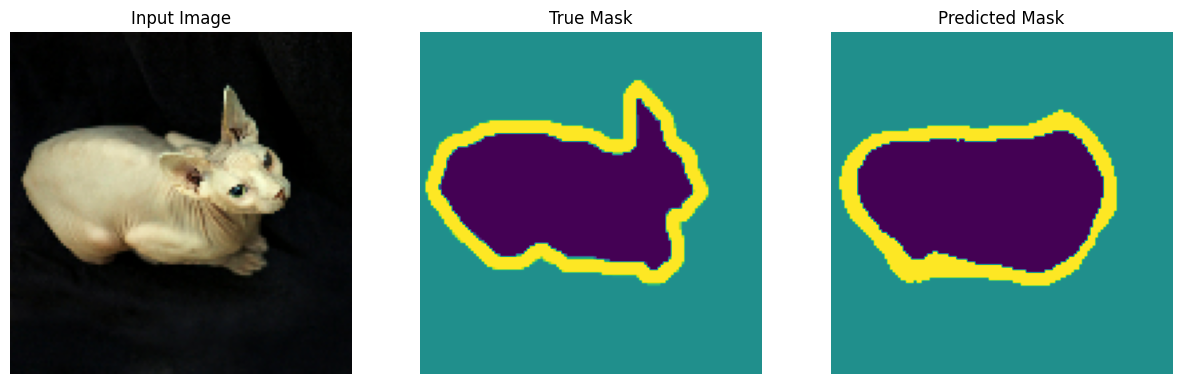


Sample Prediction after epoch 18

920/920 [==============================] - 18s 20ms/step - loss: 0.1922 - accuracy: 0.9128 - val_loss: 0.5587 - val_accuracy: 0.8120
Epoch 19/20
919/920 [============================>.] - ETA: 0s - loss: 0.1943 - accuracy: 0.9125

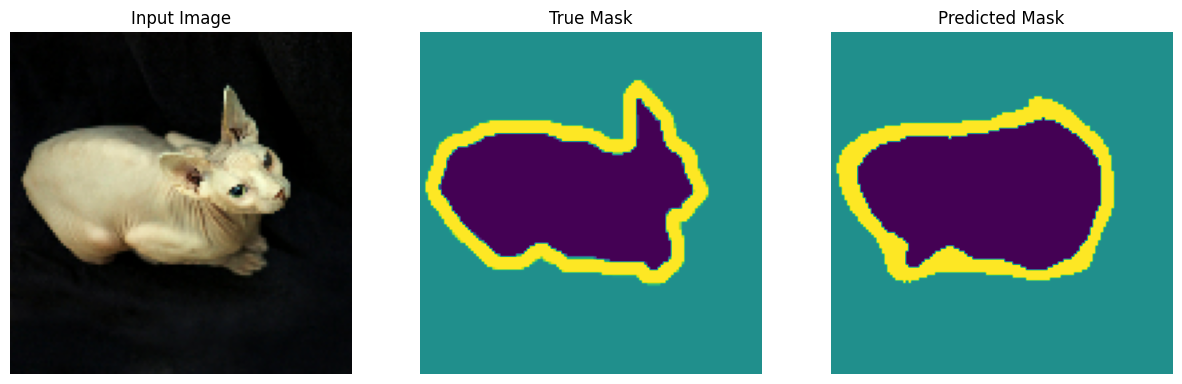


Sample Prediction after epoch 19

920/920 [==============================] - 18s 20ms/step - loss: 0.1944 - accuracy: 0.9125 - val_loss: 0.5611 - val_accuracy: 0.8098
Epoch 20/20
919/920 [============================>.] - ETA: 0s - loss: 0.1777 - accuracy: 0.9191

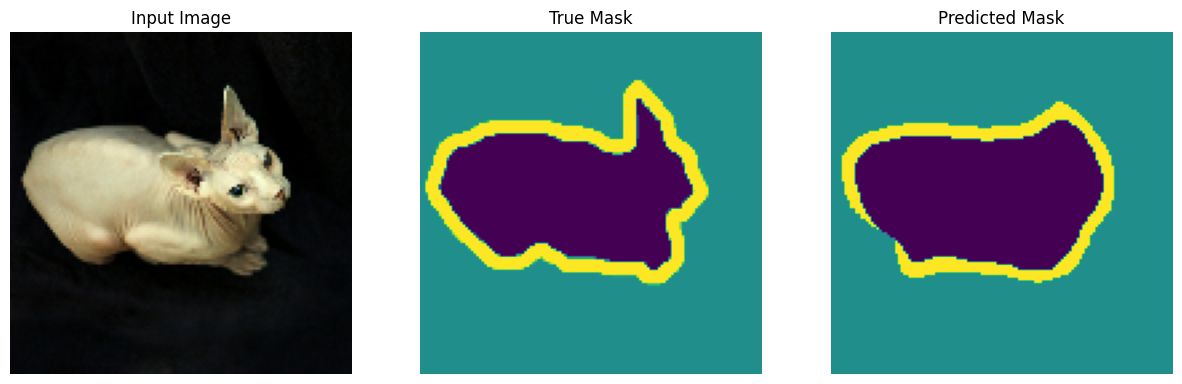


Sample Prediction after epoch 20

920/920 [==============================] - 18s 20ms/step - loss: 0.1776 - accuracy: 0.9191 - val_loss: 0.5657 - val_accuracy: 0.8031


In [10]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

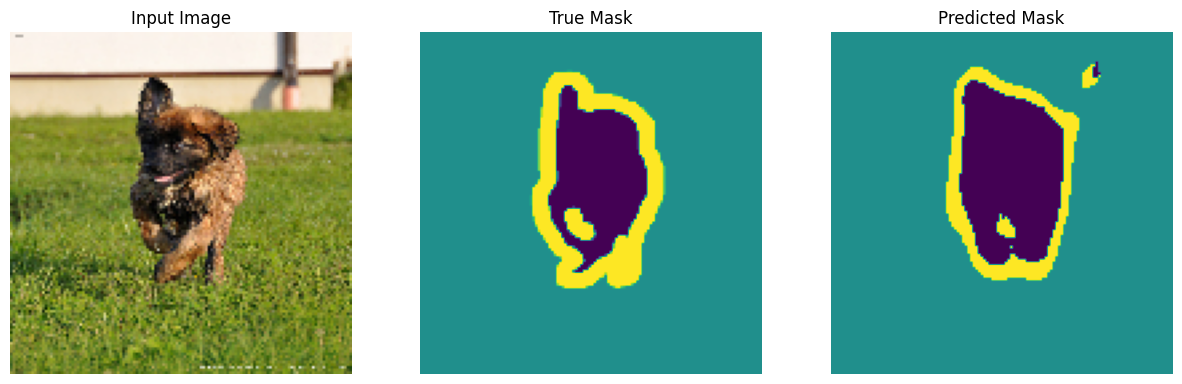

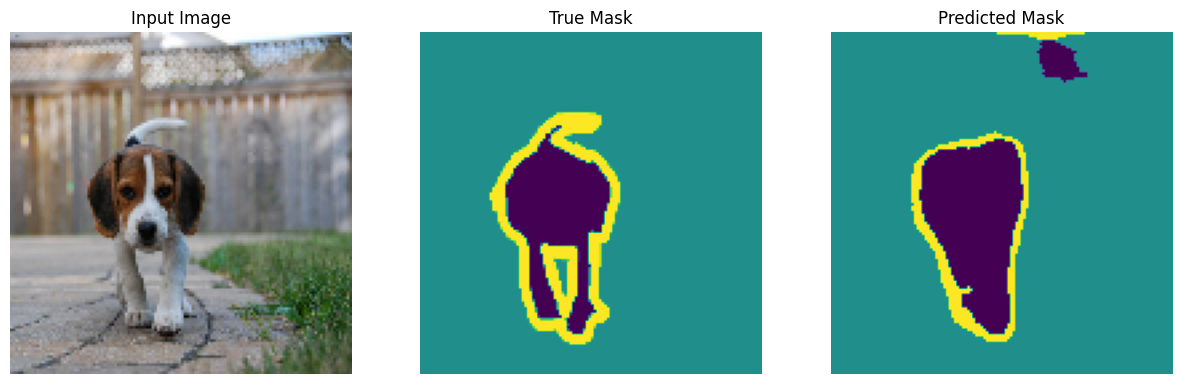

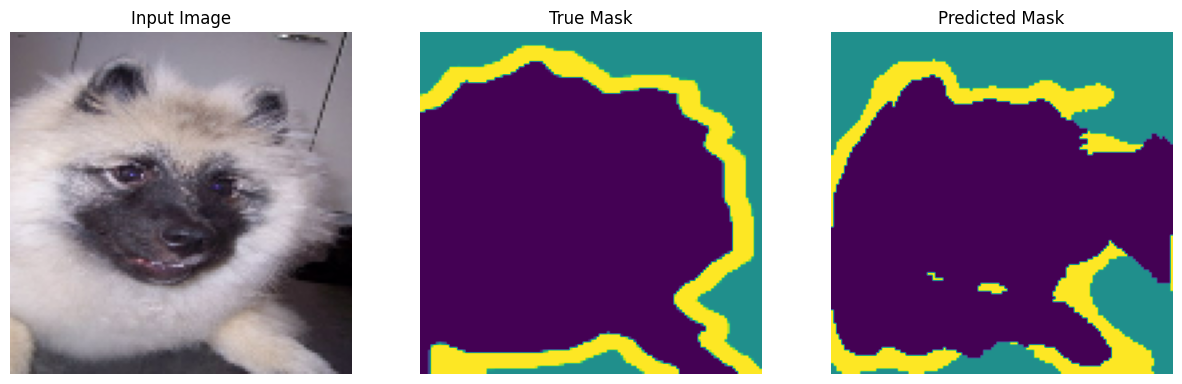

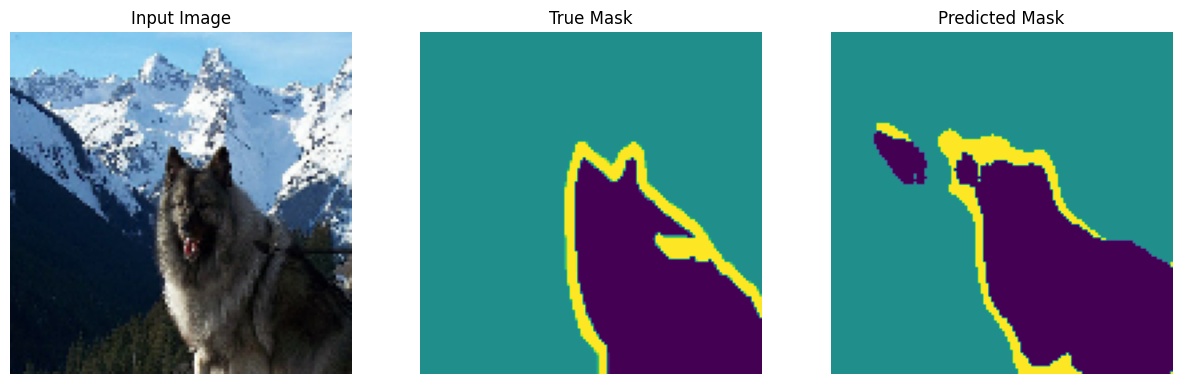

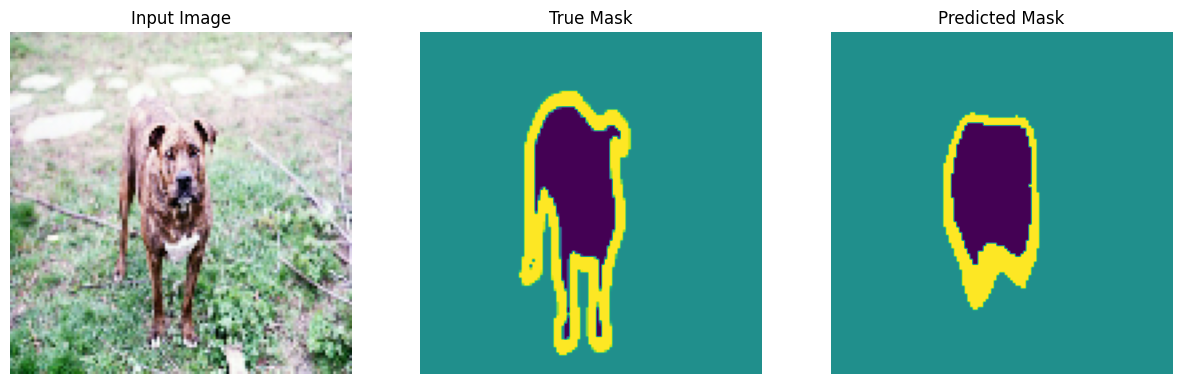

In [11]:
show_predictions(test_dataset, 5)